In [1]:
#https://vincentblog.xyz/posts/medical-images-in-python-computed-tomography
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [2]:
def crop_image(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0

    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    
    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],
                top_left[1]:bottom_right[1]]
    
    return croped_image
    
def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) / 2)
    pad_top = int((new_height - height) / 2)
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

In [4]:
def apply_ct_window(img, window):
    # window = (window width, window level)
    R = (img-window[1]+0.5*window[0])/window[0]
    R[R<0] = 0
    R[R>1] = 1
    return R
# display_img = apply_ct_window(CT, [400,50])

In [132]:
import pydicom
import SimpleITK as sk
import os
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torchio as tio
from rt_utils import RTStructBuilder
import numpy as np
%run DICOMReader.ipynb import DICOMReader

In [161]:
folder_path = "/Users/wangyangwu/Documents/Maastro/NeuralNets/PROTON/P0439C0006I1473766/RTDOSE"
subfolder_dirs = []
for roots, dirs, files in os.walk(folder_path):
    subfolder_dirs.append(roots)
subfolder_path = subfolder_dirs[1]
subfolder_path = Path(subfolder_path)
file_ids = sk.ImageSeriesReader.GetGDCMSeriesIDs(str(subfolder_path))
file_names = sk.ImageSeriesReader.GetGDCMSeriesFileNames(str(subfolder_path), file_ids[0])
series_reader = sk.ImageSeriesReader()
series_reader.SetFileNames(file_names)
image_data = series_reader.Execute()
images_3D = sk.GetArrayFromImage(image_data)


In [166]:
y = np.array([images_3D[0]]).astype("int32")

In [167]:
y.shape

(1, 99, 100, 191)

In [135]:
dicom_series_CT = "/Users/wangyangwu/Documents/Maastro/NeuralNets/PROTON/P0439C0006I1473766/CT/1.3.6.1.4.1.32722.228.6.63207665478764726756566005696578074318"
# dicom_sries_Dose = "/Users/wangyangwu/Documents/Maastro/NeuralNets/PROTON/P0439C0006I1473766/RTDOSE/1.3.6.1.4.1.32722.228.6.334797647287977966709364212462384620209/1.3.6.1.4.1.32722.228.6.36725526625681761397802081573539292769.dcm"
struct = "/Users/wangyangwu/Documents/Maastro/NeuralNets/PROTON/P0439C0006I1473766/RTSTRUCT/1.3.6.1.4.1.32722.228.6.133467612907209240084942361415930368581/1.3.6.1.4.1.32722.228.6.113839825936852261690866610346783936763.dcm"

In [136]:
rtstruct = RTStructBuilder.create_from(
  dicom_series_path=dicom_series_CT, 
  rt_struct_path=struct
)

In [137]:
## render mask layer
mask_3d_heart = rtstruct.get_roi_mask_by_name("Heart")
m = mask_3d_heart.astype("int32")
m = np.stack([m[:,:,i] for i in range(m.shape[2])])

In [138]:
images_3D = torch.from_numpy(np.stack([images_3D,images_3D]).astype("int32")).type(torch.float32)

In [139]:
images_3D.shape

torch.Size([2, 189, 512, 512])

In [140]:
m = torch.from_numpy(np.stack([m]).astype("int32")).type(torch.float32)

In [141]:
subject = tio.Subject(
    chest_ct=tio.ScalarImage(tensor=images_3D),
    heart_mask=tio.LabelMap(tensor=m),
)

In [142]:
subject.chest_ct.shape

(2, 189, 512, 512)

In [143]:
subject.heart_mask.shape

(1, 189, 512, 512)

In [144]:
dim = (512,512,512)

In [182]:
transform = tio.CropOrPad(dim,mask_name='heart_mask')

In [183]:
transformed = transform(subject)

In [184]:
transformed.chest_ct.shape

(2, 512, 512, 512)

In [185]:
t = transformed.chest_ct.numpy()

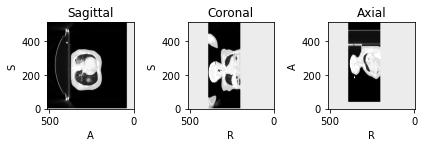

In [186]:
transformed.chest_ct.plot()

In [169]:
transform2 = tio.Pad((100,100,100,100,100,100), padding_mode=0)

In [151]:
transformed2 = transform2(subject)

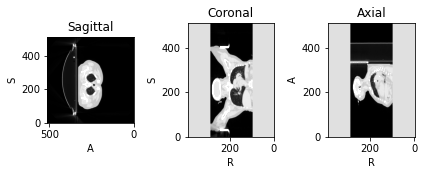

In [152]:
transformed2.chest_ct.plot()

In [153]:
reader = DICOM_reader()
reader.set_path("/Users/wangyangwu/Documents/Maastro/NeuralNets/PROTON/P0439C0006I1473766/RTDOSE/1.3.6.1.4.1.32722.228.6.334797647287977966709364212462384620209")
reader.extract_images()
# reader.visualize(True)
a = reader.get_images()
a.shape

(1, 99, 100, 191)

In [173]:
transform3 = tio.CropOrPad(dim,padding_mode=0)

In [174]:
aa = tio.ScalarImage(tensor=a)

In [175]:
bb = transform3(aa)

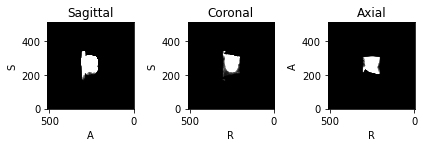

In [176]:
bb.plot()